<a href="https://colab.research.google.com/github/kevingray92/597_Project4_GroupB/blob/tuning/Project4_LinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#gfs = pd.read_csv('./raw_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
gfs = pd.read_csv('drive/My Drive/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
# gfsfs = pd.read_csv('./raw_data/GFS_Sfc_42hrFcst_2010thru2019.csv', skiprows=1, index_col = 'Date', parse_dates = True)

#oldobs = pd.read_csv('./raw_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
oldobs = pd.read_csv('drive/My Drive/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
oldobs.index = oldobs.index + pd.DateOffset(hours=12)  # Align times

#obs = pd.read_csv('./raw_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs = pd.read_csv('drive/My Drive/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs.index = obs.index + pd.DateOffset(hours=12)  # Align times

#new gfs_sfc file
gfs_sfc = pd.read_csv('drive/My Drive/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv', skiprows=0)
gfs_sfc = gfs_sfc.rename(columns={'Unnamed: 0':'Date'})
gfs_sfc['Date'] = pd.to_datetime(gfs_sfc['Date'])
gfs_sfc['Date'] = gfs_sfc['Date'] + pd.DateOffset(days = 1)  # !!Add date offset

#new gfs_prof file
gfs_prof = pd.read_csv('drive/My Drive/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv', skiprows=0)
gfs_prof = gfs_prof.rename(columns={'Unnamed: 0':'Date'})
gfs_prof['Date'] = pd.to_datetime(gfs_prof['Date'])
gfs_prof['Date'] = gfs_prof['Date'] + pd.DateOffset(days = 1) # !!Add date offset

In [0]:
# Merge and drop all days with missing values 
features = pd.merge(obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, oldobs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, gfs_sfc, how = 'inner')
features = pd.merge(features, gfs_prof, how = 'inner')
features.dropna(inplace = True)  # There are some NaNs in the observations

In [4]:
features

,Date,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,Avg DWPDEP(C),Min DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Min LCLD(%),Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa),Avg 850hPa DWPDEP(C),Min 850hPa DWPDEP(C),Max 850hPa DWPDEP(C),Avg 925hPa DWPDEP(C),Min 925hPa DWPDEP(C),Max 925hPa DWPDEP(C),Avg 250hPa HGT(m),Min 250hPa HGT(m),Max 250hPa HGT(m),Avg 500hPa HGT(m),Min 500hPa HGT(m),Max 500hPa HGT(m),Min 850hPa TMPC,Max 850hPa TMPC,Min 925hPa TMPC,Max 925hPa TMPC,Min 250hPa WSPD(m/s),Max 250hPa WSPD(m/s),Min 500hPa WSPD(m/s),Max 500hPa WSPD(m/s),Min 850hPa WSPD(m/s),Max 850hPa WSPD(m/s),Min 925hPa WSPD(m/s),Max 925hPa WSPD(m/s)
0,2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0,-10.16,-15.96,4.687217,0.00,-13.325000,-16.933333,1029.316667,286.666667,5.591667,2.250000,0.000000,3.530000,2.48,4.95,36.000000,2.0,100.0,0.111111,0.0,1.0,0.000000,0.0,0.0,1000.722222,999.8,1002.0,15.539375,5.628592,22.891972,7.057325,1.635833,10.573379,10084.972389,10036.347191,10111.956567,5400.731226,5334.628820,5437.889155,-16.522911,-14.439245,-19.584138,-15.991250,73.887425,129.448502,59.202809,81.098451,13.817925,28.554695,8.720833,28.288681
1,2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0,-9.96,-14.36,5.941380,0.06,-16.525000,-19.816667,1032.991667,296.666667,4.633333,0.000000,0.000000,3.194444,2.58,4.43,3.555556,0.0,7.0,0.222222,0.0,1.0,7.375000,0.0,42.0,1000.677778,999.2,1001.8,19.689315,14.709906,23.341408,10.718795,7.731379,15.221111,10056.572290,10038.357228,10102.468806,5427.586216,5396.740789,5455.344944,-14.410704,-11.294434,-15.187083,-12.670853,28.958127,81.202836,37.781127,53.195702,9.187170,25.595962,4.890000,14.984583
2,2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0,-8.46,-12.86,5.685068,0.17,-15.325000,-19.858333,1032.250000,305.833333,3.641667,0.000000,0.000000,2.160000,1.77,3.11,37.777778,5.0,101.0,40.888889,0.0,96.0,40.222222,0.0,97.0,998.111111,996.5,999.8,11.441479,6.692512,17.652075,5.300083,2.621395,8.373692,10010.796815,9998.993933,10029.457079,5392.037634,5385.365609,5400.031324,-11.718768,-11.160000,-14.453023,-11.653750,11.908539,29.293134,16.633220,35.140197,16.236038,22.569057,15.286250,22.735308
3,2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0,-7.16,-11.06,3.794733,0.77,-14.441667,-17.700000,1028.141667,290.833333,6.300000,1.333333,0.000000,1.876667,1.57,2.37,96.555556,76.0,100.0,16.333333,0.0,67.0,26.777778,0.0,94.0,996.388889,995.6,997.3,10.031624,3.034028,24.929242,3.466168,2.074186,7.706977,10037.582053,10009.157303,10061.734662,5414.556603,5402.594322,5422.656176,-10.760000,-8.604550,-12.781705,-10.715814,9.865169,48.420376,21.659605,28.346544,18.732500,21.650755,14.371860,20.754109
4,2010-01-06 12:00:00,-7.777778,-19.444444,3.57632,0.0,-5.46,-7.46,9.548298,7.10,-15.133333,-18.383333,1026.608333,275.833333,5.191667,3.333333,-0.008333,1.624444,1.26,2.39,77.125000,1.0,100.0,37.777778,0.0,100.0,36.666667,0.0,100.0,994.244444,991.7,996.0,14.460429,1.135714,25.413714,5.437612,1.790000,8.340388,10090.764166,10036.063321,10118.446617,5440.982389,5406.812074,5457.380510,-10.569524,-6.668571,-10.843721,-9.252248,46.999925,84.595962,23.206176,44.823732,5.498429,15.381368,4.237442,14.102946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,2019-12-26 12:00:00,16.666667,7.777778,8.04672,0.0,11.84,3.84,4.301163,0.00,10.600000,6.075000,1014.266667,185.000000,5.758333,0.000000,0.000000,1.637778,0.70,3.45,83.111111,7.0,100.0,8.444444,0.0,34.0,83.888889,29.0,100.0,988.366667,987.0,990.6,9.014899,0.078125,20.794503,1.673563,0.068047,3.831562,10610.523272,10559.985849,10645.792226,5706.442743,5692.378914,5716.411829,5.580625,12.215916,9.119687,12.394687,73.796642,101.080

In [5]:
features.describe()

,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,Avg DWPDEP(C),Min DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Min LCLD(%),Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa),Avg 850hPa DWPDEP(C),Min 850hPa DWPDEP(C),Max 850hPa DWPDEP(C),Avg 925hPa DWPDEP(C),Min 925hPa DWPDEP(C),Max 925hPa DWPDEP(C),Avg 250hPa HGT(m),Min 250hPa HGT(m),Max 250hPa HGT(m),Avg 500hPa HGT(m),Min 500hPa HGT(m),Max 500hPa HGT(m),Min 850hPa TMPC,Max 850hPa TMPC,Min 925hPa TMPC,Max 925hPa TMPC,Min 250hPa WSPD(m/s),Max 250hPa WSPD(m/s),Min 500hPa WSPD(m/s),Max 500hPa WSPD(m/s),Min 850hPa WSPD(m/s),Max 850hPa WSPD(m/s),Min 925hPa WSPD(m/s),Max 925hPa WSPD(m/s)
count,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000
mean,17.569981,6.536321,7.602858,2.039505,16.126090,7.182195,5.774674,3.312745,13.890460,6.835838,1017.482646,189.207013,5.000050,2.044747,0.071532,4.107159,1.611515,7.843521,20.903963,3.778980,46.454096,17.334272,1.129521,47.128594,36.448324,9.004946,69.883462,989.379948,986.436043,992.189026,9.093677,3.772179,15.958716,6.053299,3.048258,9.764311,10577.039885,10531.023130,10621.711348,5692.098036,5660.308408,5721.836252,5.017968,9.585280,7.283267,12.348011,45.456554,77.435117,26.751210,48.865004,12.134600,27.910239,11.238292,27.089413
std,11.909521,10.794822,2.932900,5.948541,11.217239,10.014249,2.350140,7.023797,11.962511,10.990492,7.019052,77.519042,2.360612,2.482194,0.321160,2.466752,1.627803,4.002506,27.202321,15.192854,42.995764,21.560567,7.481388,42.549424,30.265066,21.719197,37.625728,6.110867,6.583452,6.056750,6.490131,4.834662,9.368272,3.657100,2.952053,5.081807,275.251571,291.720335,259.804768,158.541059,173.458411,146.033034,10.067054,8.749075,11.306477,10.191555,26.845611,33.178013,16.693539,23.928733,8.166195,12.773453,7.513483,10.904486
min,-21.111111,-26.666667,2.235200,0.000000,-18.760000,-25.060000,1.431782,0.000000,-23.366667,-28.575000,988.527273,0.000000,0.125000,0.000000,-0.100000,0.200000,-0.040000,0.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,962.566667,954.800000,970.300000,0.266241,-0.042143,0.538578,0.125898,0.010000,0.206106,9750.421411,9706.314868,9825.928876,5141.878697,5068.047564,5197.498277,-34.508341,-23.453427,-33.376923,-24.013488,1.113585,9.278566,0.389543,5.572108,0.125118,3.279427,0.016797,4.263023
25%,8.333333,-1.111111,5.811520,0.000000,7.140000,-0.560000,4.001250,0.000000,4.379167,-1.425000,1013.221591,133.333333,3.225000,0.000000,0.000000,2.331667,0.610000,4.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.833333,0.000000,41.000000,985.661111,982.800000,988.200000,4.470450,0.581702,8.529523,3.472498,0.602899,6.231328,10359.891633,10295.279239,10420.004793,5571.042470,5526.211762,5612.940805,-2.355283,3.703692,-1.173245,5.088837,24.997151,51.787989,13.711083,29.671911,5.617704,18.132833,5.304518,18.694573
50%,20.000000,7.777778,7.152640,0.000000,18.140000,8.440000,5.393515,0.310000,16.008333,7.400000,1017.033333,190.000000,4.625000,1.142857,0.000000,3.571111,1.040000,7.470000,7.000000,0.000000,38.000000,7.666667,0.000000,46.000000,32.666667,0.000000,92.000000,989.155556,986.800000,991.600000,7.290369,2.079158,14.063455,5.475819,2.319453,8.974000,10587.595261,10543.153835,10635.297235,5712.674163,5686.208649,57

In [0]:
# Add year, month, day as integers 
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

In [0]:

# The data we will be using to predict the labels
new_features = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)
new_features_date = features.drop(columns = ['Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# Save feature list for later
feature_list = list(new_features.columns)

In [8]:
new_features

,TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,Avg DWPDEP(C),Min DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Min LCLD(%),Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa),Avg 850hPa DWPDEP(C),Min 850hPa DWPDEP(C),Max 850hPa DWPDEP(C),Avg 925hPa DWPDEP(C),Min 925hPa DWPDEP(C),Max 925hPa DWPDEP(C),Avg 250hPa HGT(m),Min 250hPa HGT(m),Max 250hPa HGT(m),Avg 500hPa HGT(m),Min 500hPa HGT(m),Max 500hPa HGT(m),Min 850hPa TMPC,Max 850hPa TMPC,Min 925hPa TMPC,Max 925hPa TMPC,Min 250hPa WSPD(m/s),Max 250hPa WSPD(m/s),Min 500hPa WSPD(m/s),Max 500hPa WSPD(m/s),Min 850hPa WSPD(m/s),Max 850hPa WSPD(m/s),Min 925hPa WSPD(m/s),Max 925hPa WSPD(m/s),year,month,day
0,-10.16,-15.96,4.687217,0.00,-13.325000,-16.933333,1029.316667,286.666667,5.591667,2.250000,0.000000,3.530000,2.48,4.95,36.000000,2.0,100.0,0.111111,0.0,1.0,0.000000,0.0,0.0,1000.722222,999.8,1002.0,15.539375,5.628592,22.891972,7.057325,1.635833,10.573379,10084.972389,10036.347191,10111.956567,5400.731226,5334.628820,5437.889155,-16.522911,-14.439245,-19.584138,-15.991250,73.887425,129.448502,59.202809,81.098451,13.817925,28.554695,8.720833,28.288681,2010,1,2
1,-9.96,-14.36,5.941380,0.06,-16.525000,-19.816667,1032.991667,296.666667,4.633333,0.000000,0.000000,3.194444,2.58,4.43,3.555556,0.0,7.0,0.222222,0.0,1.0,7.375000,0.0,42.0,1000.677778,999.2,1001.8,19.689315,14.709906,23.341408,10.718795,7.731379,15.221111,10056.572290,10038.357228,10102.468806,5427.586216,5396.740789,5455.344944,-14.410704,-11.294434,-15.187083,-12.670853,28.958127,81.202836,37.781127,53.195702,9.187170,25.595962,4.890000,14.984583,2010,1,3
2,-8.46,-12.86,5.685068,0.17,-15.325000,-19.858333,1032.250000,305.833333,3.641667,0.000000,0.000000,2.160000,1.77,3.11,37.777778,5.0,101.0,40.888889,0.0,96.0,40.222222,0.0,97.0,998.111111,996.5,999.8,11.441479,6.692512,17.652075,5.300083,2.621395,8.373692,10010.796815,9998.993933,10029.457079,5392.037634,5385.365609,5400.031324,-11.718768,-11.160000,-14.453023,-11.653750,11.908539,29.293134,16.633220,35.140197,16.236038,22.569057,15.286250,22.735308,2010,1,4
3,-7.16,-11.06,3.794733,0.77,-14.441667,-17.700000,1028.141667,290.833333,6.300000,1.333333,0.000000,1.876667,1.57,2.37,96.555556,76.0,100.0,16.333333,0.0,67.0,26.777778,0.0,94.0,996.388889,995.6,997.3,10.031624,3.034028,24.929242,3.466168,2.074186,7.706977,10037.582053,10009.157303,10061.734662,5414.556603,5402.594322,5422.656176,-10.760000,-8.604550,-12.781705,-10.715814,9.865169,48.420376,21.659605,28.346544,18.732500,21.650755,14.371860,20.754109,2010,1,5
4,-5.46,-7.46,9.548298,7.10,-15.133333,-18.383333,1026.608333,275.833333,5.191667,3.333333,-0.008333,1.624444,1.26,2.39,77.125000,1.0,100.0,37.777778,0.0,100.0,36.666667,0.0,100.0,994.244444,991.7,996.0,14.460429,1.135714,25.413714,5.437612,1.790000,8.340388,10090.764166,10036.063321,10118.446617,5440.982389,5406.812074,5457.380510,-10.569524,-6.668571,-10.843721,-9.252248,46.999925,84.595962,23.206176,44.823732,5.498429,15.381368,4.237442,14.102946,2010,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,11.84,3.84,4.301163,0.00,10.600000,6.075000,1014.266667,185.000000,5.758333,0.000000,0.000000,1.637778,0.70,3.45,83.111111,7.0,100.0,8.444444,0.0,34.0,83.888889,29.0,100.0,988.366667,987.0,990.6,9.014899,0.078125,20.794503,1.673563,0.068047,3.831562,10610.523272,10559.985849,10645.792226,5706.442743,5692.378914,5716.411829,5.580625,12.215916,9.119687,12.394687,73.796642,101.080377,49.739429,59.751371,21.320890,30.963770,21.482578,37.140781,2019,12,26
3608,13.94,3.54,8.819297,2.73,13.466667,11.141667,1016.258333,200.833333,6.125000,1.090909,0.000000,4.621111,1.05,8.39,25.333333,0.0,93.0,1.777778,0.0,15.0,59.111111,0.0,100.0,994.588889,991.2,996.5,15.569871,4.130857,20.184095,9.789371,0.451550,14.541163,10513.032500,10491.43

## Linear Regression with multiple variables; TMAX

In [0]:
# Get the verification data for training and for testing
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
train_verification = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_verification = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

In [68]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['TMAX','TMIN','tmpc','dwpc','Avg DWPDEP(C)','Avg LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Avg 925hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)','Max 925hPa TMPC','Max 850hPa TMPC','Min 925hPa TMPC','Min 850hPa TMPC'] # Choose the columns we want to use in the regression!!!
train_vars = new_features.query('year < 2019')[column_names] # Get the columns for training
test_vars = new_features.query('year == 2019')[column_names] # Get the columns for testing

lrmax.fit(train_vars, train_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
# Run the model to get predictions during the test period
predictions = lrmax.predict(test_vars)

# Print out the root mean square error (rmse), model slope, and model intercept
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, new_features.query('year == 2019')['TMAX'].values)), 2), 'degrees C.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, predictions)), 2), 'degrees C.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 4.51 degrees C.
Root Mean Square Error: 2.01 degrees C.
Model slope:     0.052450663936705964
Model intercept: 5.143152525835971


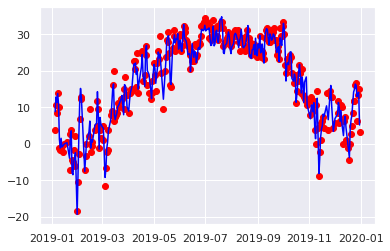

In [70]:
# Make a plot of obs during the test period (red dots) and model prediction during the test period (blue line)
plt.scatter(test_dates, test_verification, c='red')
plt.plot(test_dates, predictions, c='blue')

### Linear Regression with multiple variables; TMIN

In [0]:
# Get the verification data for training and for testing
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
train_verification = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_verification = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

In [127]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['TMAX','TMIN','tmpc','dwpc','wdir','Avg DWPDEP(C)','Avg LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Avg 925hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)','Max 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 500hPa HGT(m)','Max 925hPa TMPC','Max 850hPa TMPC','Min 925hPa TMPC','Min 850hPa TMPC'] # Choose the columns we want to use in the regression!!!
train_vars = new_features.query('year < 2019')[column_names] # Get the columns for training
test_vars = new_features.query('year == 2019')[column_names] # Get the columns for testing

lrmax.fit(train_vars, train_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [128]:
# Run the model to get predictions during the test period
predictions = lrmax.predict(test_vars)

# Print out the root mean square error (rmse), model slope, and model intercept
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, new_features.query('year == 2019')['TMIN'].values)), 2), 'degrees C.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, predictions)), 2), 'degrees C.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 4.26 degrees C.
Root Mean Square Error: 2.06 degrees C.
Model slope:     -0.013798253614427538
Model intercept: -13.820263706018746


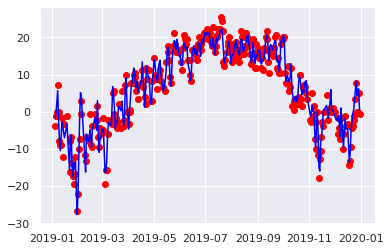

In [129]:
# Make a plot of obs during the test period (red dots) and model prediction during the test period (blue line)
plt.scatter(test_dates, test_verification, c='red')
plt.plot(test_dates, predictions, c='blue')

### Linear Regression with multiple variables; Max Wind Speed

In [0]:
# Get the verification data for training and for testing
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
train_verification = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_verification = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

In [0]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['WMAX','wspd','Max 925hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 850hPa WSPD(m/s)','Min 850hPa WSPD(m/s)','Max 500hPa WSPD(m/s)','Min 500hPa WSPD(m/s)','Min 925hPa TMPC','Max 850hPa TMPC'] # Choose the columns we want to use in the regression!!!
train_vars = new_features.query('year < 2019')[column_names] # Get the columns for training
test_vars = new_features.query('year == 2019')[column_names] # Get the columns for testing

lrmax.fit(train_vars, train_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Run the model to get predictions during the test period
predictions = lrmax.predict(test_vars)

# Print out the root mean square error (rmse), model slope, and model intercept
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, new_features.query('year == 2019')['WMAX'].values)), 2), 'm/s.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, predictions)), 2), 'm/s.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 3.32 m/s.
Root Mean Square Error: 1.92 m/s.
Model slope:     0.033181283015611386
Model intercept: 2.0822213070705455


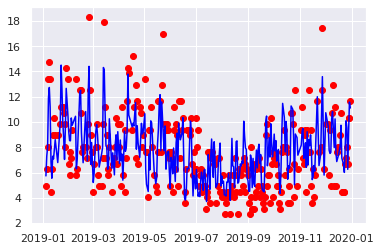

In [0]:
# Make a plot of obs during the test period (red dots) and model prediction during the test period (blue line)
plt.scatter(test_dates, test_verification, c='red')
plt.plot(test_dates, predictions, c='blue')

### Linear Regression with multiple variables; Total Precipitation

In [0]:
# Get the verification data for training and for testing
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
train_verification = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_verification = np.array(features.query('year == 2019')['Daily Precip (mm)'])

In [0]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['RTOT','dwpc','skct','Avg 850hPa DWPDEP(C)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 925hPa DWPDEP(C)','Min 925hPa DWPDEP(C)','Max 925hPa DWPDEP(C)','Max 925hPa TMPC','Min 925hPa TMPC'] # Choose the columns we want to use in the regression!!!
train_vars = new_features.query('year < 2019')[column_names] # Get the columns for training
test_vars = new_features.query('year == 2019')[column_names] # Get the columns for testing

lrmax.fit(train_vars, train_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Run the model to get predictions during the test period
predictions = lrmax.predict(test_vars)

# Print out the root mean square error (rmse), model slope, and model intercept
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, new_features.query('year == 2019')['RTOT'].values)), 2), 'mm.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, predictions)), 2), 'mm.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 8.52 mm.
Root Mean Square Error: 4.57 mm.
Model slope:     0.052581712750522085
Model intercept: 1.70943482468406


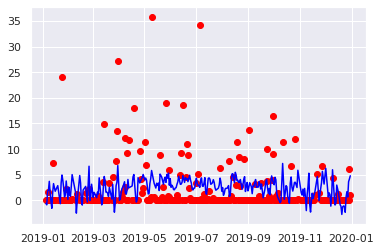

In [0]:
# Make a plot of obs during the test period (red dots) and model prediction during the test period (blue line)
plt.scatter(test_dates, test_verification, c='red')
plt.plot(test_dates, predictions, c='blue')